In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.neighbors import KNeighborsRegressor

# Environment

#### Angular Movement Environment

The agents aims to reach to a target position in a 2D space only by making unit length movements (with noise) starting from an (also noisy) initial position.

The policy $\pi$ maps the state of the agent $x_t$ to an action (angle) $a_t \in [0..2\pi]$.

Note: The environment is compatible with OpenAI.

In [2]:
class AngularMovement:

    stateDimension = 2
    actionDimension = 1

    def __init__(self, sigma_init=0.2, sigma_transition=0.2, sigma_reward=1, target=[5, 5]):
        self.initSigma = sigma_init
        self.transitionSigma = sigma_transition
        self.rewardSigma = sigma_reward
        self.targetState = target

    def init(self):
        return np.random.randn(self.stateDimension) * self.initSigma

    def transition(self, state, action):
        angle = action * 2 * math.pi
        x = state[0] + math.cos(angle) + np.random.randn() * self.transitionSigma
        y = state[1] + math.sin(angle) + np.random.randn() * self.transitionSigma

        return [x,y]

    def reward(self, states, _):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return math.exp(-sum((states[-1,:] - self.targetState) ** 2)/(2*self.rewardSigma**2))

    def step(self, state, action):

        next_state = self.transition(state, action)
        reward = self.reward(state, action)

        return next_state, reward, False, None

    def reset(self):
        return self.init()

# Utility Functions

In [3]:
def trajectory2tuples(states, actions):

    # Dimensions
    [sample_count, horizon, state_dimension] = states.shape
    [_, _, action_dimension] = actions.shape

    # Reshape Inputs and Targets
    inputs = np.reshape(states, (sample_count*horizon, state_dimension))
    targets = np.reshape(actions, (sample_count*horizon, action_dimension))

    return inputs, targets

In [4]:
def plot_trajectories(states, color='red'):

    [sample_count, _, _] = states.shape

    for s in range(sample_count):
        plt.plot(states[s, :, 0], states[s, :, 1], '-', color=color)
        plt.plot(states[s, :, 0], states[s, :, 1], 'o', color=color)
        plt.plot(states[s, -1, 0], states[s, -1, 1], 'o', color=color)

In [5]:
def plot_iteration(states, newStates):
    plot_trajectories(states, color='red')
    plot_trajectories(newStates, color='green')
    plt.plot(env.targetState[0], env.targetState[1], 'o', color='blue', markersize=20)
    plt.grid()
    plt.show()

In [6]:
def rollout_trajectories(env, policy, horizon, sample_count=1):

    # States and Actions
    states = np.zeros((sample_count, horizon, env.stateDimension))
    actions = np.zeros((sample_count, horizon, env.actionDimension))
    rewards = np.zeros((sample_count, horizon))

    # Sample Trajectories
    for s in range(sample_count):
        for t in range(horizon):

            # Initialization
            if t == 0:
                states[s,t,:] = env.reset()
            # Transition and Reward
            else:
                states[s, t, :], rewards[s,t-1], _1, _2 = env.step(states[s, t-1, :], actions[s, t-1, :])

            # Action Selection
            actions[s, t, :] = policy.query(states[s, t, :])

        _, rewards[s, horizon-1], _1, _2 = env.step(states[s, horizon-1, :], actions[s, horizon-1, :])

    return states, actions, rewards

# Monte Carlo Sampling Method

In [7]:
def importance_sampling(states, actions, rewards, policy_sample_count=0):

    # Dimensions
    [sample_count, horizon, state_dimension] = states.shape
    [_, _, action_dimension] = actions.shape

    if policy_sample_count <= 0:
        policy_sample_count = sample_count

    # Weighting
    if sum(rewards) == 0:
        weights = np.ones(sample_count) / sample_count
    else:
        weights = rewards / sum(rewards)

    # Resampling
    index = np.random.choice(range(sample_count), size=policy_sample_count, p=weights, replace=True)

    # New Trajectories
    states_new = np.zeros((policy_sample_count, horizon, state_dimension))
    actions_new = np.zeros((policy_sample_count, horizon, action_dimension))
    for s in range(policy_sample_count):
        states_new[s] = states[index[s], :, :]
        actions_new[s] = actions[index[s], :, :]

    return [states_new, actions_new]

# Policy

In [8]:
class SciKitPolicy():

    def __init__(self):
        raise NotImplementedError()

    def query(self, states):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return self.method.predict(states)

    def train(self, inputs, targets):
        self.method.fit(inputs, targets)

    def m_step(self, states, actions):

        # States/Actions -> Inputs/Targets
        inputs, targets = trajectory2tuples(states, actions)

        # Train kNN
        self.train(inputs, targets.ravel())

In [9]:
class KnnPolicyContinuous(SciKitPolicy):
    def __init__(self, k, weights='distance'):
        self.method = KNeighborsRegressor(n_neighbors=k, weights=weights, n_jobs=1)

In [10]:
class UniformPolicyContinuous():

    def __init__(self, bounds=[0,1]):
        self.min = bounds[0]      # Min Action Value
        self.max = bounds[1]      # Max Action Value

    def query(self, _):
        return self.min + np.random.random() * (self.min - self.max)

# Parameters

In [11]:
# Environment  
horizon = 10
env = AngularMovement()

# Inference
sampleCount = 2000
iterationCount = 100
selectedInference = importance_sampling

# Policy
kNearest = 5
selectedPolicy = KnnPolicyContinuous(kNearest)
policySampleCount = 100

# RLEMMC

In [12]:
iterationRewards = []

for i in range(iterationCount):

    if i == 0:
        iterationPolicy = UniformPolicyContinuous()
    else:
        iterationPolicy = selectedPolicy

    [states, actions, rewards] = \
        rollout_trajectories(env, iterationPolicy, horizon, sampleCount)

    # E-Step
    [newStates, newActions] = selectedInference(states, actions, rewards[:,-1], policySampleCount)

    # M-Step
    selectedPolicy.m_step(newStates, newActions)
    
    # Plot Trajectories
    # plot_iteration(states, newStates)
    
    # Average Reward
    iterationRewards.append(np.mean(rewards[:,-1]))
    print( f'Iteration {i+1} - Average Reward : {iterationRewards[i]}' )

Iteration 1 - Average Reward : 0.0016495850770830525
Iteration 2 - Average Reward : 0.008365745293347366
Iteration 3 - Average Reward : 0.0410486995467491
Iteration 4 - Average Reward : 0.06537037616869688
Iteration 5 - Average Reward : 0.11557826222208306
Iteration 6 - Average Reward : 0.160946405988933
Iteration 7 - Average Reward : 0.1806939849683962
Iteration 8 - Average Reward : 0.23524743663423014
Iteration 9 - Average Reward : 0.2710487464456953
Iteration 10 - Average Reward : 0.3000563193132097
Iteration 11 - Average Reward : 0.30418845932899896
Iteration 12 - Average Reward : 0.32618340499044246
Iteration 13 - Average Reward : 0.33567529794587425
Iteration 14 - Average Reward : 0.32142147780071834
Iteration 15 - Average Reward : 0.3421573261339828
Iteration 16 - Average Reward : 0.3110095260779994
Iteration 17 - Average Reward : 0.334984283051276
Iteration 18 - Average Reward : 0.333975286534323
Iteration 19 - Average Reward : 0.3425478201890478
Iteration 20 - Average Reward :

# Plots

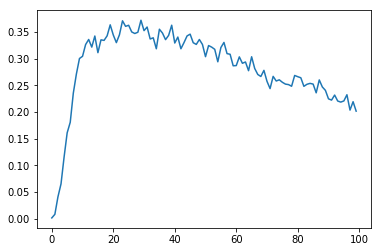

In [13]:
plt.plot(iterationRewards)
plt.show()

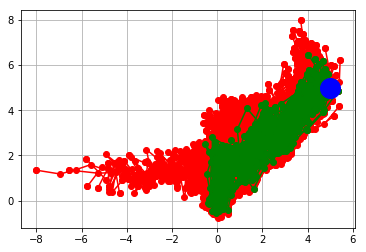

In [14]:
plot_iteration(states,newStates)